In [1]:
import time,os
import numpy as np
import cv2
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from util.plotting import plotHistory
from util.augmentation_transforms import ImageNetPolicy
from util.clr_callback import CyclicLR

In [2]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

In [3]:
train_dir = 'train'
val_dir = 'val'
train_cat_dir = 'train/cat'
train_dog_dir = 'train/dog'
val_cat_dir = 'val/cat'
val_dog_dir = 'val/dog'

#os.mkdir(val_dir)
#os.mkdir(train_cat_dir)
#os.mkdir(train_dog_dir)
#os.mkdir(val_cat_dir)
#os.mkdir(val_dog_dir)

Build Model

In [4]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [5]:
model.compile(loss='binary_crossentropy',
optimizer=optimizers.Adam(),
metrics=['acc'])

In [36]:
model.compile(loss='binary_crossentropy',
optimizer=optimizers.SGD(0.0001,0.9,nesterov=True),
metrics=['acc'])

In [46]:
model.compile(loss='binary_crossentropy',
optimizer=optimizers.SGD(0.0001),
metrics=['acc'])

Load data into numpy

In [6]:
def load_imgs(folder_,size=(150,150)):
    img_list = []
    for file_ in os.listdir(folder_):
        img_list.append(cv2.resize(cv2.imread(folder_+'/'+file_)[:,:,[2,1,0]],size))
    return np.stack(img_list,0)

In [7]:
train_X = np.concatenate([load_imgs(train_cat_dir),load_imgs(train_dog_dir)],0)

In [8]:
train_y = np.concatenate([np.ones(10000),np.zeros(10000)],0)

In [9]:
val_X = np.concatenate([load_imgs(val_cat_dir),load_imgs(val_dog_dir)],0)

In [10]:
val_y = np.concatenate([np.ones(2500),np.zeros(2500)],0)

### Adam

In [11]:
transform_fun = ImageNetPolicy()

In [12]:
datagen = ImageDataGenerator(preprocessing_function=transform_fun)
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_generator_inMem = datagen.flow(
                                train_X,train_y,
                                batch_size=50)

In [32]:
val_generator_inMem = test_datagen.flow(
                                val_X,val_y,
                                batch_size=50,shuffle=False)

In [17]:
val_predict = datagen.flow(val_X,val_y,batch_size=50,shuffle=False)

In [15]:
start = time.time()
history = model.fit_generator(
          train_generator_inMem,
          validation_data = val_generator_inMem,
          steps_per_epoch=20000/50,
          epochs=40,
          callbacks=[ReduceLROnPlateau('val_acc',factor=0.5,patience=2),EarlyStopping('val_acc',patience=4)],
          use_multiprocessing=True,workers=4,max_queue_size=100)
end = time.time()
print('time:{}'.format(end - start))

Epoch 1/40
400/400 [==============================] - 28s 71ms/step - loss: 0.6691 - acc: 0.5696 - val_loss: 0.5945 - val_acc: 0.6916
Epoch 2/40
400/400 [==============================] - 16s 40ms/step - loss: 0.5885 - acc: 0.6819 - val_loss: 0.5402 - val_acc: 0.7320
Epoch 3/40
400/400 [==============================] - 16s 39ms/step - loss: 0.5199 - acc: 0.7376 - val_loss: 0.4610 - val_acc: 0.7842
Epoch 4/40
400/400 [==============================] - 16s 40ms/step - loss: 0.4746 - acc: 0.7692 - val_loss: 0.4119 - val_acc: 0.8108
Epoch 5/40
400/400 [==============================] - 16s 40ms/step - loss: 0.4383 - acc: 0.7915 - val_loss: 0.3877 - val_acc: 0.8228
Epoch 6/40
400/400 [==============================] - 16s 39ms/step - loss: 0.4090 - acc: 0.8108 - val_loss: 0.3881 - val_acc: 0.8276
Epoch 7/40
400/400 [==============================] - 16s 40ms/step - loss: 0.3822 - acc: 0.8250 - val_loss: 0.3492 - val_acc: 0.8532
Epoch 8/40
400/400 [==============================] - 17s 43ms

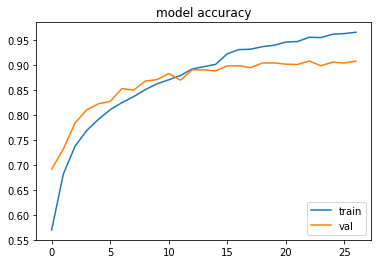

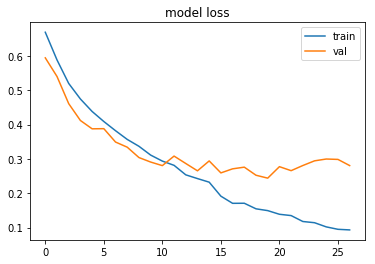

In [16]:
plotHistory(history)

TTA

In [65]:
# avg of TTA and non-TTA
accuracy_score(val_y,(yhat[:,-1] + model.predict_generator(val_generator_inMem)[:,0])>1)

0.9102

In [38]:
accuracy_score(val_y,yhat[:,0]>0.5) # wo TTA

0.9084

In [61]:
repeat_time = 20
yhat = [model.predict_generator(val_predict)[:,0] for _ in range(repeat_time)]
yhat = np.stack(yhat,1)
yhat = np.cumsum(yhat,1)/np.arange(1,repeat_time+1)

[0.8876, 0.9008, 0.902, 0.9062, 0.9074, 0.9094, 0.9092, 0.9104, 0.9118, 0.912, 0.9106, 0.9114, 0.912, 0.912, 0.9126, 0.9138, 0.9132, 0.9136, 0.913, 0.9136]


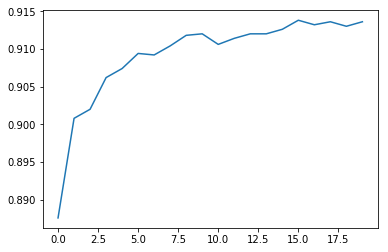

In [64]:
# TTA
temp = [accuracy_score(val_y,yhat[:,i]>0.5) for i in range(20)]
plt.plot(temp)
print(temp)

Adam with triangular

In [37]:
start = time.time()
history = model.fit_generator(
          train_generator_inMem,
          validation_data = val_generator_inMem,
          steps_per_epoch=20000/50,
          epochs=40,
          callbacks=[CyclicLR(0.002,0.09,mode='exp_range',gamma=0.9999),EarlyStopping('val_acc',patience=8)],
          use_multiprocessing=True,workers=4,max_queue_size=100)
end = time.time()
print('time:{}'.format(end - start))

Epoch 1/40
400/400 [==============================] - 18s 44ms/step - loss: 0.6763 - acc: 0.5752 - val_loss: 0.6280 - val_acc: 0.6558
Epoch 2/40
400/400 [==============================] - 17s 41ms/step - loss: 0.6241 - acc: 0.6477 - val_loss: 0.6000 - val_acc: 0.6732
Epoch 3/40
400/400 [==============================] - 17s 42ms/step - loss: 0.5591 - acc: 0.7137 - val_loss: 0.5168 - val_acc: 0.7454
Epoch 4/40
400/400 [==============================] - 17s 42ms/step - loss: 0.5107 - acc: 0.7489 - val_loss: 0.4559 - val_acc: 0.7790
Epoch 5/40
400/400 [==============================] - 17s 41ms/step - loss: 0.4969 - acc: 0.7558 - val_loss: 0.4425 - val_acc: 0.7928
Epoch 6/40
400/400 [==============================] - 16s 41ms/step - loss: 0.4627 - acc: 0.7761 - val_loss: 0.4101 - val_acc: 0.8110
Epoch 7/40
400/400 [==============================] - 17s 42ms/step - loss: 0.4115 - acc: 0.8097 - val_loss: 0.3928 - val_acc: 0.8246
Epoch 8/40
400/400 [==============================] - 17s 43ms

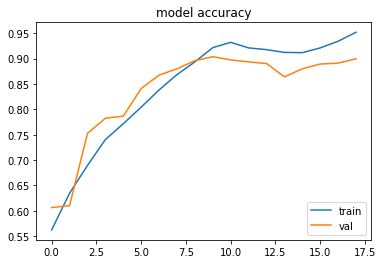

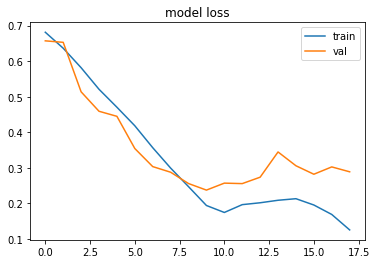

In [34]:
plotHistory(history)

### SGD + triangular learning decay

In [63]:
start = time.time()
history = model.fit_generator(
          train_generator_inMem,
          validation_data = val_generator_inMem,
          steps_per_epoch=20000/50,
          epochs=40,
          callbacks=[CyclicLR(0.0005,0.005,mode='triangular'),EarlyStopping('val_acc',patience=6)],
          use_multiprocessing=True,workers=4,max_queue_size=100)
end = time.time()
print('time:{}'.format(end - start))

Epoch 1/40
400/400 [==============================] - 21s 53ms/step - loss: 0.6905 - acc: 0.5410 - val_loss: 0.6864 - val_acc: 0.6100
Epoch 2/40
400/400 [==============================] - 20s 50ms/step - loss: 0.6786 - acc: 0.5795 - val_loss: 0.6617 - val_acc: 0.6326
Epoch 3/40
400/400 [==============================] - 20s 50ms/step - loss: 0.6646 - acc: 0.5970 - val_loss: 0.6467 - val_acc: 0.6424
Epoch 4/40
400/400 [==============================] - 21s 53ms/step - loss: 0.6440 - acc: 0.6228 - val_loss: 0.5997 - val_acc: 0.7004
Epoch 5/40
400/400 [==============================] - 21s 53ms/step - loss: 0.6113 - acc: 0.6613 - val_loss: 0.5571 - val_acc: 0.7292
Epoch 6/40
400/400 [==============================] - 21s 52ms/step - loss: 0.5673 - acc: 0.7029 - val_loss: 0.5619 - val_acc: 0.7112
Epoch 7/40
400/400 [==============================] - 20s 50ms/step - loss: 0.5344 - acc: 0.7288 - val_loss: 0.5094 - val_acc: 0.7598
Epoch 8/40
400/400 [==============================] - 20s 50ms

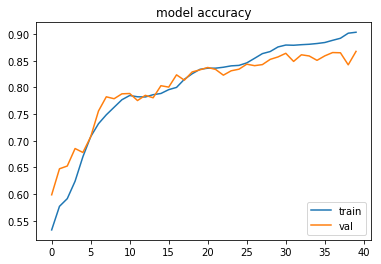

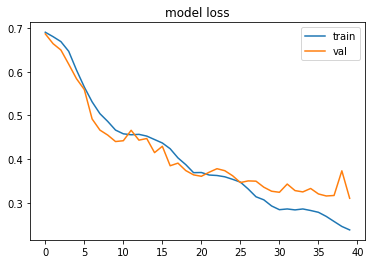

In [44]:
plotHistory(history)